# Calculate f4 statistics using the whole genome hdf5

In [326]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import socket as socket
import os as os
import sys as sys
import multiprocessing as mp
import h5py
import allel
import matplotlib.cm as cm
import matplotlib.colors as cls
import matplotlib.colorbar as clb

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM O2 Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/hapBLOCK/"  # The Path on Harvard Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)

print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")

sys.path.insert(0,"/n/groups/reich/hringbauer/git/hapBLOCK/package/hapBLOCK/IO/")  # hack to get development package first in path

compute-a-17-101.o2.rc.hms.harvard.edu
HSM O2 Computational partition detected.
/n/groups/reich/hringbauer/git/hapBLOCK
CPU Count: 32


In [272]:
def create_meta_df(f, path_meta="/n/groups/reich/hringbauer/Data/v43.4.anno.csv"):
    """Create and return Meta Dataframe that matches hdf5 in format"""
    samples = f["samples"][:]
    df_h5 = pd.DataFrame({"iid":samples})
    df_meta = pd.read_csv(path_meta)
    print(f"Loaded {len(df_meta)} Samples")
    df = pd.merge(df_h5, df_meta, on="iid", how="left")
    print(f"Created matching Meta Dataframe for h5: {len(df)}")
    df = df.reset_index(drop=True)
    df["clst"] = df["clst"].fillna("Not Available")
    return df

def get_cluster_idx(df, clst="", col_clst="clst", 
                    age_range=[], exact=False):
    """Get idcs of all samples within Cluster
    If age_range, only samples in age range"""
    if exact:
        idcs = np.where(df[col_clst]==clst)[0]
    else:
        idcs = np.where(df[col_clst].str.contains(clst))[0]
    
    ### Do additional Filtering
    if len(age_range)>0:  
        pass
    return idcs

###############################
### Calculate the Allele Counts
def get_ph(f, idcs):
    """Sample pseudohaploid data for hdf5 for
    individuals with indices idcs"""
    ads = f["calldata/AD"][:,idcs,:2]
    ads[ads<0]=0 # Set nmissing data to 0
    cov = np.sum(ads, axis=2) # get the coverage per locus/indiviual
    idx = cov>0  # Where there is some coverage
    p = np.divide(ads[:,:,1], cov, where=idx)
    ac = np.random.binomial(1,p)
    ac[~idx] = -1
    return ac

def get_gt(f, idcs):
    """Get diploid genoytpe counts"""
    gt = f["calldata/GT"][:,idcs,:]
    assert(np.min(gt)>=0)
    gt = np.sum(gt, axis=2) # Count #derived variants
    return gt

def calc_ac_from_ph(ph):
    """Calculate allele allele counts for individuals 
    with indices from hdf5 with allele counts only
    ph: Array of pseudo-haploid [l,n]"""
    c_ref=np.sum(ph==0, axis=1) # Sum the Counts over all Individuals
    c_alt=np.sum(ph==1, axis=1) # Sum the Counts over all Individuals
    
    # Double 0,0 no problem, goes to NaN and is then caught by allel
    return np.column_stack((c_ref, c_alt)) # Return the nx2 Allele Counts

def calc_ac_from_gt(gt):
    """Calculate allele allele counts for individuals 
    with indices from hdf5 with allele counts only
    ph: Array of pseudo-haploid [l,n]"""
    c_ref= 2*np.sum(gt==0, axis=1) + np.sum(gt==1, axis=1)
    c_alt= 2*np.sum(gt==2, axis=1) + np.sum(gt==1, axis=1)
    return np.column_stack((c_ref, c_alt)) # Return the nx2 Allele Counts

def get_ac_from_f(f, idcs, ph=True):
    """Get Allele Counts from HDF, 
    grouped for all indivdiuals in idcs
    ph: Whether to use pseudo-haploid or diploid genotypes"""
    if ph:
        ph = get_ph(f, idcs)
        ac = calc_ac_from_ph(ph=ph)
    else:
        print("Using diploid mode...")
        gt = get_gt(f, idcs)
        ac = calc_ac_from_gt(gt)
    return ac

def calculate_ac_pop(clst, f, df, col="clst", exact=False):
    """Return allele counts for population.
    exact: whether ther is an exact match"""
    idcs = get_cluster_idx(df, clst=clst, exact=exact,
                           col_clst=col)
    ac = get_ac_from_f(f, idcs) 
    return ac

def calculate_ac_pops(pops, f, df, col="clst", ph=True, 
                      exact=False, out=True):
    """Calculate list of allele counts [l,2] for pops
    f: hdf5
    df: metafile matching f
    pops: List of populations to extract ACs for"""
    acs=[]
    for pop in pops:
        idcs = get_cluster_idx(df=df, clst=pop, exact=exact)
        if len(idcs)==0:
            raise RuntimeWarning(f"No matching iids for {pop} not found!!")
        if out:
            print(f"Calculating counts pop: {pop}, n={len(idcs)}...")
        ac = get_ac_from_f(f, idcs, ph=ph) 
        acs.append(ac)
    return acs

###########################################
### Calculate the actual f statistics

def f3_ac(pt, p1, p2, snps_okay=None, blen=1000):
    """Calculate f3 for Allele Counts (lx2 arrays)
    snps_okay: Which SNPs to actually use. If none use all
    blen: Block Nr for Bootstrap
    """
    #f3 = np.mean((pt-p1)*(pt-p2))
    f3 = allel.average_patterson_f3(pt, p1, p2, blen=blen, normed=False)
    return [f3[0], f3[1], f3[2]]  # f4, se, z

def f4_ac(p1, p2, p3, p4, snps_okay=None, blen=1000):
    """Calculate f4 for Allele Counts (lx2 arrays)
    snps_okay: Which SNPs to actually use. if none use all
    blen: Block Nr for Bootstrap
    """
    f4 = allel.average_patterson_d(p1, p2, p3, p4, blen=blen)
    return [f4[0], f4[1], f4[2]]  # f4, se, z

def fst_ac(p1, p2, blen=1000):
    """Calculate f3 for Allele Counts (lx2 arrays)
    blen: Block Nr for Bootstrap
    A sim wrapper, so later on different methods can be implemented.
    Return fst, se, z value (based on jackkniving)
    """
    res = allel.average_patterson_fst(p1, p2, blen=blen)
    
    f4, se = res[0], res[1]
    z = f4 / se # Calculate the z-Value
    return [res[0], res[1], z]  # f4, se, z

### Load the data

In [261]:
f = h5py.File("./data/hdf5/1240k_v43/all_ch.h5", "r")
df = create_meta_df(f, path_meta="/n/groups/reich/hringbauer/Data/v43.4.anno.csv")

Loaded 18171 Samples
Created matching Meta Dataframe for h5: 14523


### Calculate some Allele Counts

In [234]:
acs = calculate_ac_pops(pops=["Italy_Sardinia_N", "Italy_Sardinia_EBA", "Russia_Samara_EBA_Yamnaya.SG", "Mbuti.DG"], f=f, df=df, col="clst", 
                  exact=True, out=True, ph=True)
ac_sar_n=acs[0]
ac_sar_eba=acs[1]
ac_yam=acs[2]
ac_mbuti=acs[3]
ac_sar_med = calculate_ac_pop(clst="Italy_Sardinia_Medieval", 
                          f=f, df=df, col="clst", exact=True)
ac_anatolia_n = calculate_ac_pop(clst="Turkey_N", 
                          f=f, df=df, col="clst", exact=True)
ac_jomon_hg = calculate_ac_pop(clst="Japan_HG_Jomon", 
                          f=f, df=df, col="clst", exact=True)
ac_karitian = calculate_ac_pop(clst="Karitiana.DG", 
                          f=f, df=df, col="clst", exact=True) 
ac_japan = calculate_ac_pop(clst="Japanese.DG", 
                          f=f, df=df, col="clst", exact=True)

Calculating counts pop: Italy_Sardinia_N, n=12...
Calculating counts pop: Italy_Sardinia_EBA, n=18...
Calculating counts pop: Russia_Samara_EBA_Yamnaya.SG, n=14...
Calculating counts pop: Mbuti.DG, n=4...


### Calculate the diploid genotypes allele counts

In [273]:
acs = calculate_ac_pops(pops=["Mbuti.DG", "Japanese.DG", "Karitiana.DG", "Sardinian.DG", 
                              "Han.DG", "Korean.DG"], 
                        f=f, df=df, col="clst", 
                        exact=True, out=True, ph=False)
ac_mbuti2=acs[0]
ac_japan2=acs[1]
ac_karitiana2=acs[2]
ac_sardinia2=acs[3]
ac_han2=acs[4]
ac_korean2=acs[5]

Calculating counts pop: Mbuti.DG, n=4...
Using diploid mode...
Calculating counts pop: Japanese.DG, n=3...
Using diploid mode...
Calculating counts pop: Karitiana.DG, n=3...
Using diploid mode...
Calculating counts pop: Sardinian.DG, n=3...
Using diploid mode...
Calculating counts pop: Han.DG, n=3...
Using diploid mode...
Calculating counts pop: Korean.DG, n=2...
Using diploid mode...


### Calculate f4 statistics

In [350]:
#f4, se, z = f4_ac(acs[0], acs[1], acs[2], acs[3])
f4, se, z = f4_ac(ac_anatolia_n, ac_yam, ac_jomon_hg, ac_japan2)
f4, se, z

(0.00927567871242395, 0.001838476637629443, 5.045306816835126)

In [259]:
#f4, se, z = f4_ac(acs[0], acs[1], acs[2], acs[3])
f4, se, z = f4_ac(ac_anatolia_n, ac_yam, ac_jomon_hg, ac_japan)
f4, se, z

(0.009067118603175033, 0.0018571802471125198, 4.882196338924172)

In [265]:
df[df["clst"].str.contains("Korea")].sort_values(by="age")[:50]

,iid,Master ID,lat,lon,age,region,study,clst,mean_cov,n_cov_snp,avg_cov_snp,include_alt,family
379,S_Korean-1.DG,ND19394,37.6,127.0,0.0,South Korea,MallickNature2016,Korean.DG,0.933030,1119636.0,44.32,True,n/a (no relatives detected)
637,S_Korean-2.DG,NA00726,37.6,127.0,0.0,South Korea,MallickNature2016,Korean.DG,0.932992,1119590.0,53.33,True,n/a (no relatives detected)


In [316]:
df[df["clst"].str.contains("Ainu")]

,iid,Master ID,lat,lon,age,region,study,clst,mean_cov,n_cov_snp,avg_cov_snp,include_alt,family
1487,I2102,I2102,NaN,NaN,250.0,Japan,Unpublished / Unclaimed,Japan_Ainu,0.211376,253651.0,0.271,True,n/a (no relatives detected)


# Plot F Statistics

In [341]:
# Function for the Plotting
def plot_bars(f_scores, se, z_scores, labels, ylabel="Test Statistic", label=True,
             pop_labels=[], pop_labels_c=[], figsize=(12,8), save_path=""):
    """Plot f-scores and their errors of n results
    f_scores, se, z_scores: Arrays of the results, length n
    labels: Array of the labels, length n
    label: Boolean, whether to plot the Text on Top
    pop_label: Array of pop-labels, length n; Default = [] does not plot anything 
    pop_label_c: Colors of the pop-label; Default = [] does not plot anything
    save_path: String. If given, save figure in this path.
    """
    k = len(f_scores)
    x_arr = np.arange(k) + 0.5
    
    cmap0 = cm.get_cmap(name='RdBu')
    #cmap0 = plt.cm.get_cmap('coolwarm')  # Get custom cmap binary
    norm0 = cls.Normalize(vmin=-5, vmax=5) # The normaliztion, mapping values to colors between 0 and 1
    colors = [cmap0(norm0(i)) for i in z_scores]
    #colors="firebrick"
    
    fs=16
    f = plt.figure(figsize=figsize) 
    ax = plt.gca()  # Get the Axis object.
    pl = ax.bar(x_arr, f_scores, yerr=se, color = colors)
    plt.xticks(x_arr, labels, rotation="vertical", fontsize=12)
    ax.set_ylabel(ylabel, fontsize=fs)
    ax.set_xlabel("Population x", fontsize=fs)
    plt.plot([0,k+0.5],[0,0],"darkgreen",linewidth=2)   # Plot Null line
    
    
    # Create custom colorbar
    f.subplots_adjust(right=0.85)
    ax1 = f.add_axes([0.88, 0.17, 0.02, 0.66])
    cb1 = clb.ColorbarBase(ax1, cmap=cmap0,
                                norm=norm0,
                                orientation='vertical')
    cb1.set_label('z-Value', fontsize=12, rotation=270, labelpad=14)
    
     # Write the z-Score on top:
    
    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax = plt.gca()
            ax.text(rect.get_x() + rect.get_width()*2/3., 1.3*height,
                    '%.3g' % float(height),
                    ha='center', va='bottom')
    
    if label==True:
        autolabel(pl)
    
    ### If population Labels given
    if len(pop_labels_c)>0:   
        # Set the colors of the Labels
        for xtick, color in zip(ax.get_xticklabels(), pop_labels_c):
            xtick.set_color(color)
        
        # Make a legend of the Population Labels:
        ax.legend(loc='upper left') # frameon=False
        
        def create_proxy(label, color):
            """Create empty handles for legends"""
            handle = plt.Line2D([], [], color=color, markersize=100, label=label)
            return handle
        
        _, ind = np.unique(pop_labels, return_index=True)  # Get Indices of unique Labels
        #inds = np.sort(ind) # Sort them to get them ordered
        
        handles = [create_proxy(pop_labels[i], pop_labels_c[i]) for i in ind]
        ax.legend(handles = handles, loc = "upper right", fontsize=fs)  
    
    if len(save_path)>0:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0)
    plt.show()

# Do f4 stats for various east Asian populations

In [345]:
%%time
ac_targets =[ac_sardinia2, ac_jomon_hg, ac_japan2, ac_han2, ac_korean2, ac_karitiana2]
labels = ["Sardinia", "Jomon_HG", "Japan", "Han", "Korean", "Karitiana"]
f4s, ses, zs=[], [], []

for ac in ac_targets:
    f4, se, z = f4_ac(ac_anatolia_n, ac_yam, ac, ac_mbuti2)
    f4s.append(f4)
    ses.append(se)
    zs.append(z)

CPU times: user 1.98 s, sys: 80.9 ms, total: 2.06 s
Wall time: 2.06 s


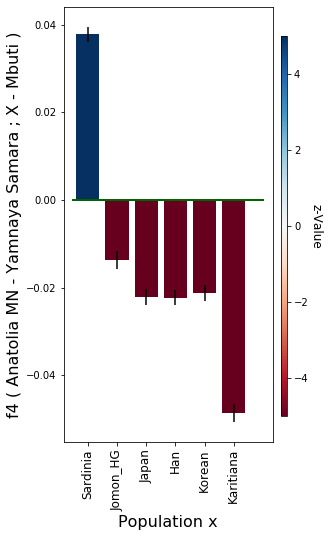

In [349]:
plot_bars(f4s, ses, zs, labels, ylabel="f4 ( Anatolia MN - Yamnaya Samara ; X - Mbuti )", label=False,
             pop_labels=[], pop_labels_c=[], figsize=(4,8), save_path="./figs/dumpster/f4_stats_jomon.png")